In [1]:
import gensim.downloader as api
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, LSTM
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EMBEDDING_DIMENSIONALITY = 300

# load in dataset
dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
samples = dataset.data
labels = dataset.target

In [3]:
# tokenize words from samples
tokenizer = Tokenizer()
tokenizer.fit_on_texts(samples)
num_words = len(tokenizer.word_index) + 1

# convert to sequences and pad sequences to all be same size
sequences = tokenizer.texts_to_sequences(samples)
padded_sequences = pad_sequences(sequences, maxlen=EMBEDDING_DIMENSIONALITY)

In [4]:
# partition data
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, shuffle=True)

In [5]:
# load in embeddings and create embedding matrix
embeddings = api.load("word2vec-google-news-300")

embedding_matrix = np.zeros((num_words, EMBEDDING_DIMENSIONALITY))
for word, index in tokenizer.word_index.items():
    if word in embeddings:
        embedding_matrix[index] = embeddings[word]

In [6]:
# create CNN model and compile
model = Sequential([
    Embedding(input_dim=num_words, output_dim=EMBEDDING_DIMENSIONALITY, weights=[embedding_matrix], input_length=EMBEDDING_DIMENSIONALITY, trainable=False),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(3),
    Conv1D(128, 5, activation="relu"),
    LSTM(100),
    Dense(20, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          47453100  
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                        

In [7]:
# train model
model_history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
106/106 [==============================] - 23s 195ms/step - loss: 2.2482 - accuracy: 0.2459 - val_loss: 1.8106 - val_accuracy: 0.3760
Epoch 2/20
106/106 [==============================] - 22s 204ms/step - loss: 1.6028 - accuracy: 0.4382 - val_loss: 1.4883 - val_accuracy: 0.4821
Epoch 3/20
106/106 [==============================] - 22s 210ms/step - loss: 1.3344 - accuracy: 0.5271 - val_loss: 1.3348 - val_accuracy: 0.5332
Epoch 4/20
106/106 [==============================] - 24s 229ms/step - loss: 1.1615 - accuracy: 0.5996 - val_loss: 1.2584 - val_accuracy: 0.5623
Epoch 5/20
106/106 [==============================] - 26s 249ms/step - loss: 1.0247 - accuracy: 0.6466 - val_loss: 1.1788 - val_accuracy: 0.5995
Epoch 6/20
106/106 [==============================] - 24s 226ms/step - loss: 0.9569 - accuracy: 0.6739 - val_loss: 1.1003 - val_accuracy: 0.6240
Epoch 7/20
106/106 [==============================] - 23s 214ms/step - loss: 0.8191 - accuracy: 0.7230 - val_loss: 1.0483 - val_ac

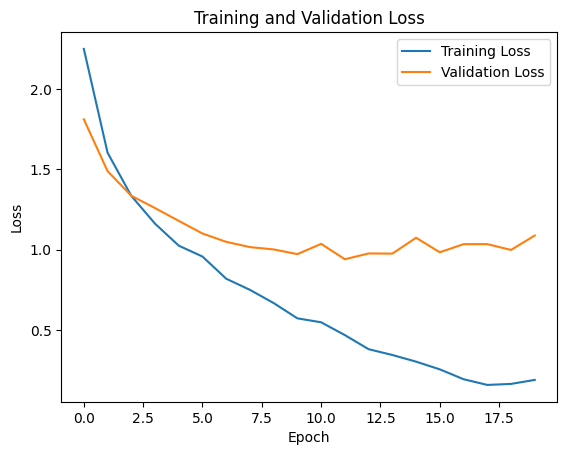

In [8]:
# plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 4s 30ms/step
Accuracy: 0.7448275862068966
